In [1]:
import numpy as np
import pandas as pd
import os
import pprint
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
import warnings
import matplotlib
from os import listdir
import seaborn as sns
import scipy
import sys
import pickle
import miceforest as mf
warnings.filterwarnings("ignore")
import functools
from functools import reduce
from mc4.algorithm import mc4_aggregator
from copy import deepcopy

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import missingpy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score, log_loss, roc_auc_score
from collections import Counter
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import NearMiss
from collections import Counter

import shap
import matplotlib.pyplot as plt
import statsmodels.api as sm
from torch.utils.data import Dataset, DataLoader

In [2]:
rs = 42

In [3]:
import random

def _init_fn(worker_id):
    np.random.seed(int(rs))
    
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()

In [4]:
# Undersample Test Set
test_under_sampler = 0
do_class_weight = 1

# Undersample Train Set
do_smote = 0
do_random_under_sampler = 1
do_random_over_sampler = 0
do_tomek_links = 0
do_near_miss = 0

In [5]:
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

In [6]:
os.chdir('..')

In [7]:
prediction_window = "24h"

In [8]:
data_directory = 'AKI Data/eicu_aki/new data/'
prediction_directory = 'observation' + prediction_window + '_prediction24h/'

data_files = find_csv_filenames(data_directory+prediction_directory)

hosps = [x.replace('.csv', '') for x in data_files]

In [9]:
model_directory = 'AKI Models/' + prediction_window + '/Pytorch MLP/'

#### Loading Cleaned Data

In [10]:
def get_features_diag(data):
    features = list(data_dictionary[hosp])
    features.remove(list(data_dictionary[hosp])[-1])
    AKI_diag = list(data_dictionary[hosp])[-1]
    return features, AKI_diag

def do_training_modifications(X_train, y_train):
    if do_smote:
        oversample = SMOTE(random_state=rs)
        X_train, y_train = oversample.fit_resample(X_train, y_train)
    if do_random_under_sampler:
        rus = RandomUnderSampler(replacement=True, random_state=rs)
        X_train, y_train = rus.fit_resample(X_train, y_train)
    if do_random_over_sampler:
        ros = RandomOverSampler(random_state=rs)
        X_train, y_train = ros.fit_resample(X_train, y_train)
    if do_tomek_links:
        tl = TomekLinks(random_state=rs)
        X_train, y_train = tl.fit_resample(X_train, y_train)
    if do_near_miss:
        nm = NearMiss(random_state=rs)
        X_train, y_train = nm.fit_resample(X_train, y_train)  
    return X_train, y_train

def normalize_data(data_dictionary, hosp):
    df = deepcopy(data_dictionary[hosp])
    demographic_index = list(df).index('is_female')
    medical_signs = list(df)[:demographic_index]
    medication_index = list(df).index('ACETAMIN')
    medications = list(df)[medication_index:len(list(data))-1]
    demographic_binary = ['is_female', 'race_black', 'race_hispanic', 'race_asian', 
                        'race_other', 'electivesurgery']
    binary_features = medications + demographic_binary
    continuous_features = medical_signs + ['age', 'BMI']

    df[continuous_features] = (df[continuous_features]-df[continuous_features].mean())/df[continuous_features].std()
    df[binary_features] = df[binary_features].replace([0],-1)
    return df

In [11]:
temp_data_dictionary = dict.fromkeys(hosps)
data_dictionary = dict.fromkeys(hosps)
missing_dictionary = dict.fromkeys(hosps)

In [12]:
for hosp in data_dictionary:
    file = str(hosp) + '.csv'
    data = pd.read_csv(data_directory + prediction_directory + "cleaned/" + file)
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    data_dictionary[hosp] = data

In [13]:
for hosp in data_dictionary:
    data_dictionary[hosp] = normalize_data(data_dictionary, hosp)

#### Functions for Model Training and Validation

In [14]:
class MLP(nn.Module):
    def __init__(self,input_shape):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(input_shape,10)
        self.fc2 = nn.Linear(10,1)
    
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
    def fit(self, X_train, y_train, epochs=200, lr=0.001):
        X_train = X_train.values
        y_train = y_train.values
        class_weights = sklearn.utils.compute_class_weight('balanced', classes=np.unique(np.squeeze(y_train)),
                                                           y=np.squeeze(y_train))
        trainset = dataset(X_train, y_train)
        train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers = 0, worker_init_fn=_init_fn)
        criterion = nn.BCELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        self.train_model(train_loader, criterion, optimizer, epochs, class_weights)
        return self
    
    def fit_history(self, X_train, y_train, X_test, y_test, epochs=200, lr=0.001):
        X_train = X_train.values
        y_train = y_train.values
        class_weights = sklearn.utils.compute_class_weight('balanced', classes=np.unique(np.squeeze(y_train)),
                                                           y=np.squeeze(y_train))
        trainset = dataset(X_train, y_train)
        train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers = 0, worker_init_fn=_init_fn)
        criterion = nn.BCELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        training_aucs, testing_aucs, losses = self.train_model_history(train_loader, criterion, optimizer, epochs, X_train,
                                                y_train, X_test.values, y_test.values, class_weights)
        return self, training_aucs, testing_aucs, losses
    
    def predict_prob(self, X):
        with torch.no_grad():
            return np.array(self(torch.tensor(X,dtype=torch.float32)).flatten())
        
    def get_predictions(self, X_test):
        with torch.no_grad():
            predicted = self(torch.tensor(X_test,dtype=torch.float32))
            predictions_one_encoded = predicted.reshape(-1).detach().numpy().round()
            return np.array(predicted).flatten(), predictions_one_encoded
        
    def train_model(self, train_loader, criterion, optimizer, epochs, class_weights):
        for i in range(epochs):
            for j,(x_train,y_train) in enumerate(train_loader):
                #calculate output
                output = self(x_train)
                # set criterion weight
                batch_class_weights = y_train.clone().detach()
                batch_class_weights[batch_class_weights == 0] = class_weights[0]
                batch_class_weights[batch_class_weights == 1] = class_weights[1]
                criterion.weight = batch_class_weights.reshape(-1,1)
                #calculate loss
                loss = criterion(output,y_train.reshape(-1,1))
                #backprop
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
    
    def train_model_history(self, train_loader, criterion, optimizer, epochs, all_x_train, all_y_train, all_x_test, all_y_test, class_weights):
        losses = []
        training_aucs = []
        testing_aucs = []
        for i in range(epochs):
            running_loss = 0.0
            for j,(x_train,y_train) in enumerate(train_loader):
                #calculate output
                output = self(x_train)
                # set criterion weight
                batch_class_weights = y_train.clone().detach()
                batch_class_weights[batch_class_weights == 0] = class_weights[0]
                batch_class_weights[batch_class_weights == 1] = class_weights[1]
                criterion.weight = batch_class_weights.reshape(-1,1)
                #calculate loss
                loss = criterion(output,y_train.reshape(-1,1))
                #backprop
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            probs, preds = self.get_predictions(all_x_train)
            probs = probs.flatten()
            training_aucs.append(np.round(roc_auc_score(all_y_train, probs), 3))
            probs, preds = self.get_predictions(all_x_test)
            probs = probs.flatten()
            testing_aucs.append(np.round(roc_auc_score(all_y_test, probs), 3))
            losses.append(running_loss)
        return training_aucs, testing_aucs, losses
    
    def get_weights(self):
        return self.state_dict()
    
class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.length = self.x.shape[0]
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length    


In [15]:
def evaluate_model_optim(model, y_test, X_test, print_dist=False):
    y_test = y_test.values
    probs, predictions = model.get_predictions(X_test.values)
    y_pred_coded = predictions
    probs = probs.flatten()
    if print_dist == True:
        print("Distribution of Test Predictions")
        pred_class_distribution(y_test, y_pred_coded)
        print("###########")
    metric=[]
    metric.append(['accuracy',np.round(accuracy_score(y_test,y_pred_coded), 3)])
    roc_score = np.round(roc_auc_score(y_test, probs), 3)
    metric.append(['roc',np.round(roc_score, 3)])
    metric.append(['precision',np.round(precision_score(y_test,y_pred_coded), 3)])
    metric.append(['recall',np.round(recall_score(y_test,y_pred_coded), 3)])
    return metric

def pred_class_distribution(y_test, y_pred_coded):
    zero_wrong, zero_right, one_wrong, one_right = [0] * 4
    for i in range(0, len(y_pred_coded)):
        if y_test[i] == 0:
            if y_pred_coded[i] == 0:
                zero_right += 1
            else:
                zero_wrong += 1
        if y_test[i] == 1:
            if y_pred_coded[i] == 1:
                one_right += 1
            else:
                one_wrong += 1
    print("Number of 0 Class Predictions Right: " + str(zero_right))
    print("Number of 0 Class Predictions Wrong: " + str(zero_wrong))
    print("Number of 1 Class Predictions Right: " + str(one_right))
    print("Number of 1 Class Predictions Wrong: " + str(one_wrong))

#### Local Models

In [16]:
def get_cross_validated_scores(X, Y, partial_fit=False, model_name=None, model=None):
    cv = sklearn.model_selection.StratifiedKFold(n_splits=5,shuffle=True, random_state=rs)
    
    all_training_aucs = []
    all_testing_aucs = []
    all_losses = []
    count = 1
    for train, test in cv.split(X, Y):
        input_size = X.shape[1]
        model = MLP(input_size)
        X_train = X.iloc[train]
        y_train = Y.iloc[train]
        X_test = X.iloc[test]
        y_test = Y.iloc[test]
        model, training_aucs, testing_aucs, losses = model.fit_history(X_train, y_train, X_test, y_test, epochs=200, lr=0.01)
        
        all_training_aucs.append(training_aucs)
        all_testing_aucs.append(testing_aucs)
        all_losses.append(losses)
        count += 1

    return all_training_aucs, all_testing_aucs, all_losses

In [17]:
local_models_training_auc_history = dict.fromkeys(hosps)
local_models_testing_auc_history = dict.fromkeys(hosps)
local_models_loss_history = dict.fromkeys(hosps)

In [18]:
for i, hosp in enumerate(data_dictionary):
    data = data_dictionary[hosp]
    features, AKI_diag = get_features_diag(data)
    X = data[features]
    Y = data[AKI_diag]
    
    training_aucs, testing_aucs, losses = get_cross_validated_scores(X, Y, model_name=hosp)
    
    local_models_training_auc_history[hosp] = training_aucs
    local_models_testing_auc_history[hosp] = testing_aucs
    local_models_loss_history[hosp] = losses
    print("Done with " + str(i+1) + " out of " + str(len(data_dictionary)) + " models", end="\r")
    
print("Finished Training all Models")

Finished Training all Models


#### Federated Models

In [19]:
def get_fed_cross_validated_scores(hosps, model_name='fed'):
    splits = 5
    cv = sklearn.model_selection.StratifiedKFold(n_splits=splits,shuffle=True, random_state=rs)
    
    all_training_aucs = []
    all_testing_aucs = []
    all_losses = []
    
    for split_count in range(splits):    
        X_training_dictionary = dict.fromkeys(hosps)
        X_testing_dictionary = dict.fromkeys(hosps)
        y_training_dictionary = dict.fromkeys(hosps)
        y_testing_dictionary = dict.fromkeys(hosps)

        for hosp in data_dictionary:
            data = data_dictionary[hosp]
            features, AKI_diag = get_features_diag(data)
            X = data[features]
            Y = data[AKI_diag]
            train, test = get_fold_info(split_count, cv.split(X, Y))
            X_training_dictionary[hosp] = X.iloc[train]
            X_testing_dictionary[hosp] = X.iloc[test]
            y_training_dictionary[hosp] = Y.iloc[train]
            y_testing_dictionary[hosp] = Y.iloc[test]
        
        input_size = len(features)
        model, hosp_training_aucs, hosp_testing_aucs, hosp_losses = create_federated_model_history(X_training_dictionary, y_training_dictionary, 
                                                                             X_testing_dictionary, y_testing_dictionary, input_size, num_epochs = 200)
        
        all_training_aucs.append(hosp_training_aucs)
        all_testing_aucs.append(hosp_testing_aucs)
        all_losses.append(hosp_losses)
    
    return all_training_aucs, all_testing_aucs, all_losses


def get_fold_info(split_count, gen):
    j = 0
    for train, test in gen:
        train = train
        test = test
        if split_count == j:
            break
        j += 1
    return train, test

In [20]:
def create_federated_model_history(X_training_dictionary, y_training_dictionary, X_testing_dictionary, 
                                   y_testing_dictionary, input_size, num_epochs = 200):
    device = 'cpu'
    # Set the model to train and send it to device.
    global_model = model = MLP(input_size)
    global_model.to(device)
    global_model.train()
    # copy weights
    global_weights = global_model.state_dict()
    
    hosp_training_aucs = dict.fromkeys(hosps)
    hosp_testing_aucs = dict.fromkeys(hosps)
    hosp_losses_aucs = dict.fromkeys(hosps)
    for hosp in hosps:
        hosp_training_aucs[hosp] = []
        hosp_testing_aucs[hosp] = []
        hosp_losses_aucs[hosp] = []    
    
    for epoch in tqdm(range(num_epochs)):
        local_weights = []
        global_model.train()
        for hosp in hosps:
            local_model = deepcopy(global_model)
            X_train = X_training_dictionary[hosp]
            y_train = y_training_dictionary[hosp]
            X_test = X_testing_dictionary[hosp]
            y_test = y_testing_dictionary[hosp]
            local_model, training_aucs, testing_aucs, losses = local_model.fit_history(X_train, y_train, X_test, y_test, epochs=1, lr=0.01)
            hosp_training_aucs[hosp].append(training_aucs)
            hosp_testing_aucs[hosp].append(testing_aucs)
            hosp_losses_aucs[hosp].append(losses)
            w = local_model.get_weights()
            local_weights.append(deepcopy(w))
        # update global weights
        global_weights = average_weights(local_weights)
        # update global weights
        global_model.load_state_dict(global_weights)
    
    return global_model, hosp_training_aucs, hosp_testing_aucs, hosp_losses_aucs  

def average_weights(w):
    w_avg = deepcopy(w[0])
    for key in w_avg.keys():
        for i in range(1, len(w)):
            w_avg[key] += w[i][key]
        w_avg[key] = torch.div(w_avg[key], len(w))
    return w_avg

In [21]:
all_training_aucs, all_testing_aucs, all_losses = get_fed_cross_validated_scores(hosps, model_name='fed')

100%|███████████████████████████████████████████| 200/200 [00:26<00:00,  7.52it/s]


In [22]:
fed_model_training_auc_history = dict.fromkeys(hosps)
fed_model_testing_auc_history = dict.fromkeys(hosps)
fed_model_losses_history = dict.fromkeys(hosps)

for hosp in hosps:
    fed_training_aucs = []
    fed_testing_aucs = []
    fed_training_losses = []
    for i in range(0, 5):
        fed_training_aucs.append(np.squeeze((np.array(all_training_aucs[i][hosp]))))
        fed_testing_aucs.append(np.squeeze((np.array(all_testing_aucs[i][hosp]))))
        fed_training_losses.append(np.squeeze((np.array(all_losses[i][hosp]))))
    fed_model_training_auc_history[hosp] = np.array(fed_training_aucs)
    fed_model_testing_auc_history[hosp] = np.array(fed_testing_aucs)
    fed_model_losses_history[hosp] = np.array(fed_training_losses)

### Plotting Model Performances

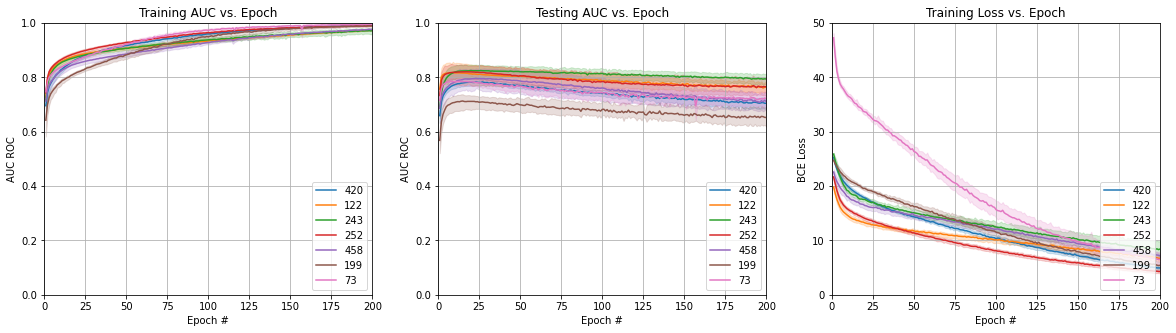

In [23]:
num_rows = 1
num_cols = 3

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20,5))

ax = axes[0]
for hosp in hosps:
    a = np.concatenate(np.array(local_models_training_auc_history[hosp]))
    d = pd.DataFrame(data=a, columns=['metrics'])
    epochs = np.linspace(1, 200, num=200).astype(int)
    d['Epochs'] = np.concatenate([epochs] * 5, axis=0)
    sns.lineplot(data=d, x="Epochs", y="metrics", ax=ax, label=hosp)
ax.set_xlim([0, 200])
ax.set_ylim([0, 1])
ax.set_title("Training AUC vs. Epoch")
ax.set_ylabel("AUC ROC")
ax.set_xlabel("Epoch #")
ax.legend(loc="lower right")
ax.grid()


ax = axes[1]
for hosp in hosps:
    a = np.concatenate(np.array(local_models_testing_auc_history[hosp]))
    d = pd.DataFrame(data=a, columns=['metrics'])
    epochs = np.linspace(1, 200, num=200).astype(int)
    d['Epochs'] = np.concatenate([epochs] * 5, axis=0)
    sns.lineplot(data=d, x="Epochs", y="metrics", ax=ax, label=hosp)
ax.set_xlim([0, 200])
ax.set_ylim([0, 1])
ax.set_title("Testing AUC vs. Epoch")
ax.set_ylabel("AUC ROC")
ax.set_xlabel("Epoch #")
ax.legend(loc="lower right")
ax.grid()


ax = axes[2]
for hosp in hosps:
    a = np.concatenate(np.array(local_models_loss_history[hosp]))
    d = pd.DataFrame(data=a, columns=['metrics'])
    epochs = np.linspace(1, 200, num=200).astype(int)
    d['Epochs'] = np.concatenate([epochs] * 5, axis=0)
    sns.lineplot(data=d, x="Epochs", y="metrics", ax=ax, label=hosp)
ax.set_xlim([0, 200])
ax.set_ylim([0, 50])
ax.set_title("Training Loss vs. Epoch")
ax.set_ylabel("BCE Loss")
ax.set_xlabel("Epoch #")
ax.legend(loc="lower right")
ax.grid()

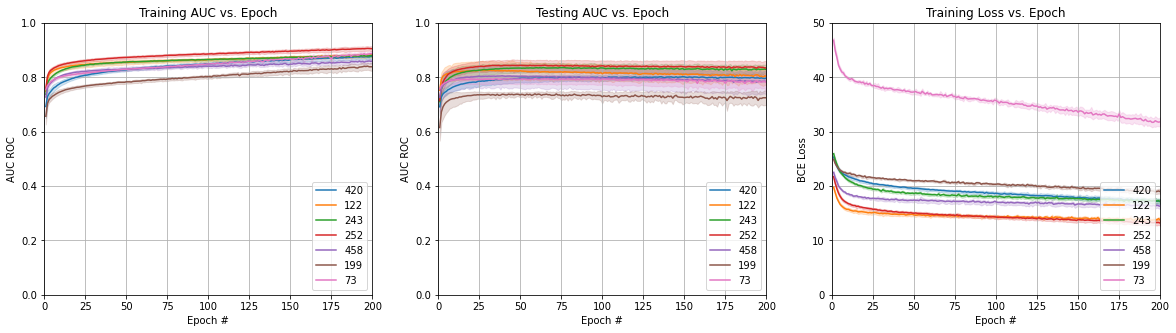

In [24]:
num_rows = 1
num_cols = 3

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20,5))

ax = axes[0]
for hosp in hosps:
    a = np.concatenate(np.array(fed_model_training_auc_history[hosp]))
    d = pd.DataFrame(data=a, columns=['metrics'])
    epochs = np.linspace(1, 200, num=200).astype(int)
    d['Epochs'] = np.concatenate([epochs] * 5, axis=0)
    sns.lineplot(data=d, x="Epochs", y="metrics", ax=ax, label=hosp)
ax.set_xlim([0, 200])
ax.set_ylim([0, 1])
ax.set_title("Training AUC vs. Epoch")
ax.set_ylabel("AUC ROC")
ax.set_xlabel("Epoch #")
ax.legend(loc="lower right")
ax.grid()


ax = axes[1]
for hosp in hosps:
    a = np.concatenate(np.array(fed_model_testing_auc_history[hosp]))
    d = pd.DataFrame(data=a, columns=['metrics'])
    epochs = np.linspace(1, 200, num=200).astype(int)
    d['Epochs'] = np.concatenate([epochs] * 5, axis=0)
    sns.lineplot(data=d, x="Epochs", y="metrics", ax=ax, label=hosp)
ax.set_xlim([0, 200])
ax.set_ylim([0, 1])
ax.set_title("Testing AUC vs. Epoch")
ax.set_ylabel("AUC ROC")
ax.set_xlabel("Epoch #")
ax.legend(loc="lower right")
ax.grid()


ax = axes[2]
for hosp in hosps:
    a = np.concatenate(np.array(fed_model_losses_history[hosp]))
    d = pd.DataFrame(data=a, columns=['metrics'])
    epochs = np.linspace(1, 200, num=200).astype(int)
    d['Epochs'] = np.concatenate([epochs] * 5, axis=0)
    sns.lineplot(data=d, x="Epochs", y="metrics", ax=ax, label=hosp)
ax.set_xlim([0, 200])
ax.set_ylim([0, 50])
ax.set_title("Training Loss vs. Epoch")
ax.set_ylabel("BCE Loss")
ax.set_xlabel("Epoch #")
ax.legend(loc="lower right")
ax.grid()